In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import os

2024-02-12 15:09:40.768026: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 15:09:41.568664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 15:09:41.568721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 15:09:41.607769: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 15:09:41.726545: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 15:09:41.727924: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
Test_dataset_path ='/home/anishdabhane/Projects/2nd_year/PBL/MobileNet_V2/dataset/data/test/'
Training_dataset_path ='/home/anishdabhane/Projects/2nd_year/PBL/MobileNet_V2/dataset/data/train/'

In [3]:

def dataset_visualization(path):
    files = os.listdir(path)
    tot=0
    x=[]
    y=[]
    for file in files:
        images=os.listdir(path+"/"+file)
        x.append(file)
        y.append(len(images))
    
    plt.bar(x,y,width=0.5)
    plt.xlabel("Categories")
    plt.ylabel("No of images")
    plt.xticks(rotation=45, ha='right')
    plt.show()

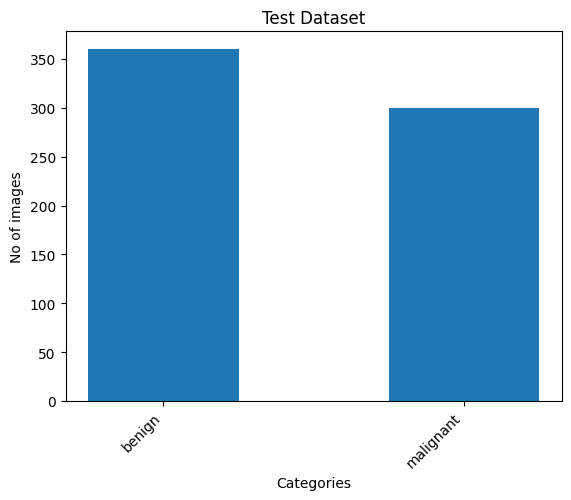

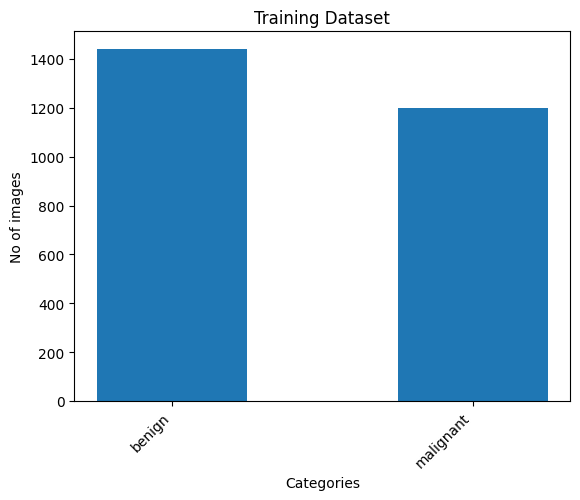

In [4]:

plt.title("Test Dataset")
dataset_visualization(Test_dataset_path)
plt.title("Training Dataset")
dataset_visualization(Training_dataset_path)

In [5]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(Training_dataset_path),
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(Test_dataset_path),
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2637 files belonging to 2 classes.
Found 660 files belonging to 2 classes.


In [6]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


Model building

In [9]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

base_model = mobilenet_v2

In [10]:
feature_extractor_layer = hub.KerasLayer(
    base_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [11]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [12]:
num_classes = 2

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [13]:
predictions = model(image_batch)

In [14]:
predictions.shape

TensorShape([32, 2])

In [15]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


In [16]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS)

Epoch 1/10


83/83 [==============================] - 116s 1s/step - loss: 0.5206 - acc: 0.7520 - val_loss: 0.3925 - val_acc: 0.8258
Epoch 2/10
83/83 [==============================] - 110s 1s/step - loss: 0.3607 - acc: 0.8407 - val_loss: 0.3607 - val_acc: 0.8439
Epoch 3/10
83/83 [==============================] - 100s 1s/step - loss: 0.3259 - acc: 0.8555 - val_loss: 0.3484 - val_acc: 0.8424
Epoch 4/10
83/83 [==============================] - 103s 1s/step - loss: 0.3046 - acc: 0.8695 - val_loss: 0.3427 - val_acc: 0.8348
Epoch 5/10
83/83 [==============================] - 109s 1s/step - loss: 0.2876 - acc: 0.8768 - val_loss: 0.3394 - val_acc: 0.8485
Epoch 6/10
83/83 [==============================] - 110s 1s/step - loss: 0.2718 - acc: 0.8878 - val_loss: 0.3616 - val_acc: 0.8500
Epoch 7/10
83/83 [==============================] - 108s 1s/step - loss: 0.2687 - acc: 0.8904 - val_loss: 0.3402 - val_acc: 0.8545
Epoch 8/10
83/83 [==============================] - 120s 1s/step - loss: 0.2515 - acc: 0.8965 

In [18]:
model.save('fine-tuned_mobilenet_v2.h5')

/home/anishdabhane/Projects/2nd_year/PBL/MobileNet_V2/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
